In [1]:
import sys
import os
import importlib
from pathlib import Path
import pickle
import importlib

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.signal import find_peaks
import plotly.express as px
import plotly.graph_objects as go


%matplotlib widget
# sns.set_context('talk')

%tb
from eidynamics import utils, data_quality_checks, ephys_classes, abf_to_data, expt_to_dataframe
import parse_data
import all_cells

No traceback available to show.


Data parsing program imported
>> Working on:  C:\Users\adity\OneDrive\NCBS


In [35]:
datapath = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\EI_Dynamics\Analysis\parsed_data\all_cells_convergence_combined.h5")
data = pd.read_hdf(datapath, key='data')

In [51]:
from eidynamics import expt_to_dataframe
importlib.reload(expt_to_dataframe)

<module 'eidynamics.expt_to_dataframe' from 'c:\\Users\\adity\\OneDrive\\NCBS\\Lab\\Projects\\EI_Dynamics\\Analysis\\eidynamics\\expt_to_dataframe.py'>

In [52]:
metadata, analysed_params = expt_to_dataframe.add_analysed_params2(data.iloc[:10,:], 'convergence', 50000, 20)

KeyError: 'numPulses'

In [50]:
metadata.iloc[0,:]

cellID                                                           1981
sex                                                                 F
ageAtInj                                             36 days 00:00:00
ageAtExpt                                           129 days 00:00:00
incubation                                           93 days 00:00:00
unit                                                               pA
location                                                          CA1
protocol                                                  convergence
exptSeq                                                             0
exptID                                                              3
sweep                                                               1
stimFreq                                                           50
numSq                                                               5
intensity                                                         100
pulseWidth          

In [34]:
# save the dataframes as short and long forms
metadata.to_hdf('all_cells_VC_FreqSweep_short.h5', key='data')
analysed_params.to_hdf('all_cells_VC_FreqSweep_long.h5', key='data')

C:\Users\adity\AppData\Local\Temp\ipykernel_15924\594220095.py:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block4_values] [items->Index(['sex', 'unit', 'location', 'protocol', 'numSq', 'clampMode',
       'clampPotential', 'condition', 'numPatterns', 'patternList',
       'frameChangeTimes', 'pulseTimes'],
      dtype='object')]

  metadata.to_hdf('all_cells_VC_FreqSweep_short.h5', key='data')
C:\Users\adity\AppData\Local\Temp\ipykernel_15924\594220095.py:3: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0] [items->None]

  analysed_params.to_hdf('all_cells_VC_FreqSweep_long.h5', key='data')
C:\Users\adity\AppData\Local\Temp\ipykernel_15924\594220095.py:3: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it canno

In [24]:
row = analysed_params.iloc[666,:]

In [28]:
me, pa, cell, frame, led, field = row.iloc[:34], row.iloc[34:104], row.iloc[104:20104], row.iloc[20104:40104], row.iloc[40104:60104], row.iloc[60104:]

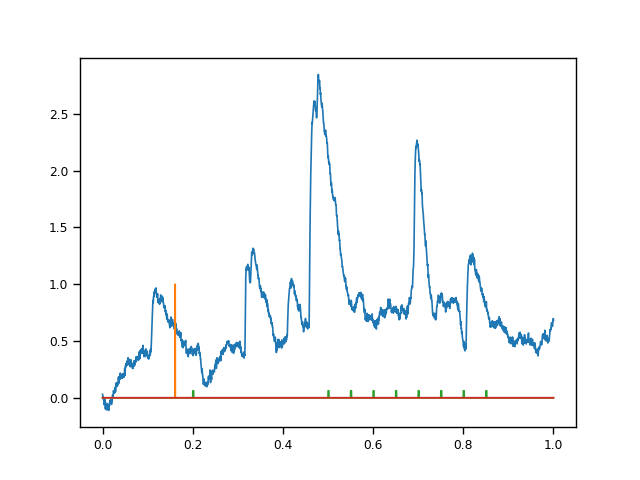

In [29]:
plt.figure()
plt.plot(np.linspace(0,1,20000), cell, label='cell')
plt.plot(np.linspace(0,1,20000), frame, label='frame')
plt.plot(np.linspace(0,1,20000), led, label='led')
plt.plot(np.linspace(0,1,20000), field, label='field')
plt.show()

In [148]:
pa[8:20]

locs_8           0.84995
peaks_cell_0    0.341381
peaks_cell_1    0.800753
peaks_cell_2    0.780868
peaks_cell_3    0.624219
peaks_cell_4    0.431727
peaks_cell_5    1.333914
peaks_cell_6    1.547801
peaks_cell_7    0.345965
peaks_cell_8    0.364111
peak_field_0         0.0
peak_field_1         0.0
Name: 678, dtype: object

### Things to show
1. first pulse response: peak, slope, auc
2. FPR vs PPR
3. PPR vs pulse number for E/I, numSq, stimFreq
4. STPR vs pulse number for E/I, numSq, stimFreq
5. Spike train STA
6. Upi's model
7. Gabazine causes spikes
8. SDN

## 1. FPR

In [ ]:
vcdata.iloc[0,:34]['pulseTimes']

#### STA

In [ ]:
def plot_spike_train_STA(data, squares='all', save_fig=True):
    cell = np.array(data[0][0])
    led = np.array(data[0][2])
    if squares=5:
        numSweeps = np.array([1,9,17, 2,10,18, 3,11,19, 4,12,20, 5,13,21])-1
    elif squares=15:
        numSweeps = np.array([6,14,21, 7,15,22, 8,16,23])-1
    elif squares = 'all':
        numSweeps = np.arange(0,24)

    fig, ax = plt.subplots(1,1,figsize=(10,10))
    mean_sta = np.zeros((len(numSweeps), 2000))
    for n, s in enumerate(numSweeps):
        trial_cell = cell[s,:]
        trial_stim = led[s,:]
        peaks, _ = find_peaks(trial_cell, height=50, distance=100)
        numEvents = len(peaks)
        pre_event_stim = np.zeros((numEvents,2000))
        print(n, s, numEvents)
        for i in range(numEvents):
            pre_event_stim[i,:] = trial_stim[peaks[i]-2000:peaks[i]]
            # draw individual stim slices
            # ax.plot(np.linspace(-100, 0, 2000), pre_event_stim[i,:], color='k', alpha=0.05)
        mean_sta[n,:] = np.mean(pre_event_stim, axis=0)
        # make a filled plot of mean sta
        ax.fill_between(np.linspace(-100, 0, 2000), np.mean(pre_event_stim, axis=0), color='k', alpha=0.2)

    ax.set_xlabel('Time before a spike event (ms)')
    ax.set_ylabel('LED intensity (a.u.)')
    ax.set_title( 'Spike Triggered Average for {} sq patterns'.format(squares) )

    # show figure and save
    if save_fig:
        filename1 = 'sta_{}sq.svg'.format(squares)
        filename2 = 'sta_{}sq.png'.format(squares)
        plt.savefig(filename1)
        plt.savefig(filename2)


In [ ]:
train_ctrl_data = train_ctrl_data = abf_to_data.abf_to_data(spiketrain_ctrl_path, filter_type='bessel', filter_cutoff=2000,data_order="channelwise", sweep_baseline_epoch=[0, 0.2], baseline_subtraction=True)

In [ ]:
plot_spike_train_STA(train_ctrl_data, squares='all', save_fig=False)